# Intro to Vision Transformer

이 노트북은 Vision Transformer (ViT [1]) 에 대한 이해를 돕기 위해서 만들어졌습니다. 이 노트북은 아래와 같은 내용을 포함하고 있습니다.

0. 기본 연산자
1. ViT 모델 핵심 모듈 살펴보기기
    - Patch Embedding Layer
    - Transformer Encoder
2. ViT 전체 모델 아키텍쳐 및 추론 결과 확인
3. Hybrid 모델 아키텍쳐 및 추론 결과 확인

## Further reading

이 노트북을 마치고 난 후 아래 자료들을 더 보시면 좋습니다.

- [vit-pytorch github](https://github.com/lucidrains/vit-pytorch) : 다양한 ViT 모델을 간단한 코드로 확인이 가능합니다.
- [timm](https://github.com/rwightman/pytorch-image-models): 다양한 pre-trained 모델을 사용해 볼 수 있습니다.
- [Introduction to PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html): 모든 ViT 의 기반이 되는 머신러닝 framework 에 대한 기초를 다져보세요.
- [Attention is all you need](https://arxiv.org/abs/1706.03762): Transformer 의 기원이 되는 논문 입니다.
- [annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html): Transformer 를 end-to-end 로 공부해보세요.

## Reference

[1]: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale, arXiv, 2020

## 1. 데이터셋 다운로드 및 전처리 코드

In [1]:
!wget -nc https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01440764_tench.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01484850_great_white_shark.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01491361_tiger_shark.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01622779_great_grey_owl.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01629819_European_fire_salamander.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01630670_common_newt.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01631663_eft.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01632458_spotted_salamander.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01632777_axolotl.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01641577_bullfrog.JPEG
!wget -nc https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01644373_tree_frog.JPEG
!pip3 install rich timm

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# utils
import json
import numpy as np
from PIL import Image
from torchvision import transforms as TF
from torchsummary import summary
from rich import print

# draw image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# machine learning
import torch
from torch import nn
from timm import create_model
from timm.models.vision_transformer import VisionTransformer
from timm.layers.helpers import to_2tuple


matplotlib.rcParams.update({'font.size': 12})


with open('imagenet-simple-labels.json') as f:
    imagenet_labels = json.load(f)


def class_id_to_label(i):
    return imagenet_labels[i]


def img_resize(img, size=224, ratio=0.875):
    trans = TF.Compose([
        TF.Resize(int(size / ratio)),
        TF.CenterCrop(size),
    ])
    img = trans(img)

    return img


def img_to_tensor(img, size=224, ratio=0.875):
    trans = TF.Compose([
        TF.Resize(int(size / ratio)),
        TF.CenterCrop(size),
        TF.ToTensor(),
        TF.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    tensor = trans(img)

    return tensor


def show_prediction_with_img(probs, preds, ys, imgs):
    probs = probs.detach().cpu()
    preds = preds.detach().cpu()
    ys = ys.detach().cpu()

    column = 4
    total = len(probs) * 2
    row = total // column
    plt.figure(figsize=(25, 3 * total // 2))

    idx = 1
    for b in range(len(probs)):
        color = ['r' if i else 'b' for i in (preds[b] == ys[b]).tolist()]
        label = [class_id_to_label(i) for i in preds[b].tolist()]

        plt.subplot(row, column, idx)
        plt.imshow(imgs[b])
        plt.axis('off')
        plt.gca().set_title(class_id_to_label(ys[b]))
        idx += 1

        plt.subplot(row, column, idx)
        plt.bar(label, probs[b], color=color)
        plt.xticks(rotation=20)
        idx += 1
    plt.show()


def show_patch(img, batch, indices):
    batch = batch.detach().cpu()

    b = len(batch)
    c = len(indices) + 1
    total = b * c

    plt.figure(figsize=(c * 3, b * 3))

    idx = 1
    for i in range(b):
        plt.subplot(b, c, idx)
        plt.imshow(img[i])
        plt.gca().set_title("Input image")
        plt.axis('off')
        idx += 1
        for j in indices:
            plt.subplot(b, c, idx)
            plt.imshow(batch[i, j], cmap='cividis')
            plt.axis('off')
            plt.gca().set_title(f"Channel ID {j+1}/{batch.size(1)}")
            idx += 1

    plt.show()


def show_attn(img, batches, layers, indices, head=6):
    batches = [batches[i].detach().cpu() for i in range(len(batches))]

    b = len(batches[0])
    c = len(indices)
    ll = len(layers)
    total = b * c * (ll + 1)

    plt.figure(figsize=((ll + 1) * 3, b * c * 3))

    idx = 1
    for i in range(b):
        for j in indices:
            if j != 0:
                plt.subplot(b * c, ll + 1, idx)
                plt.imshow(img[i])
                plt.tick_params(left=False, bottom=False, labelleft=False , labelbottom=False)
                idx += 1
                rr, cc = divmod(j, 14)
                h, w, _ = np.asarray(img[i]).shape
                rect = patches.Rectangle((cc/14 * w, rr/14 * h), 14 * (w / 224), 14 * (h / 224), linewidth=3,
                                         edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
                plt.gca().set_title("Input image")
            else:
                plt.subplot(b * c, ll + 1, idx)
                plt.text(0.2, 0.5, '[class token]', fontdict={'size': 16})
                plt.axis('off')
                idx += 1

            for l in layers:
                plt.subplot(b * c, ll + 1, idx)
                plt.imshow(img[i])
                plt.imshow(batches[l][i, :, j, 1:].mean(dim=0).reshape(14, 14), cmap='cividis')
                plt.tick_params(left=False, bottom=False, labelleft=False , labelbottom=False)
                plt.gca().set_title(f"Layer {l + 1}")
                # if j == 0:
                #     plt.gca().set_title(f"{l + 1} layer")
                idx += 1

    plt.subplots_adjust(left=0.15,
                bottom=0.0,
                right=1.0,
                top=1,
                wspace=0.0,
                hspace=0.0)
    plt.show()

img_path_label = [
    ('n01440764_tench.JPEG',0),('n01443537_goldfish.JPEG',1),('n01484850_great_white_shark.JPEG',2),
    ('n01491361_tiger_shark.JPEG',3),('n01622779_great_grey_owl.JPEG',24),('n01629819_European_fire_salamander.JPEG',25),
    ('n01630670_common_newt.JPEG',26),('n01631663_eft.JPEG',27),('n01632458_spotted_salamander.JPEG',28),
    ('n01632777_axolotl.JPEG',29),('n01641577_bullfrog.JPEG',30),('n01644373_tree_frog.JPEG',31),
]

imgs = []
xs = []
xs_384 = []
ys = []

for img_path, label in img_path_label:
    img = Image.open(img_path)
    x = img_to_tensor(img)
    x_384 = img_to_tensor(img, 384, 1.0)
    imgs.append(img_resize(img))
    xs.append(x)
    xs_384.append(x_384)
    ys.append(torch.tensor(label))

xs = torch.stack(xs, dim=0)
xs_384 = torch.stack(xs_384, dim=0)
ys = torch.stack(ys, dim=0)


class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(
            self,
            img_size=224,
            patch_size=16,
            in_chans=3,
            embed_dim=768,
            **kwargs
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        return x


class Attention(nn.Module):
    """ Multi-headed Self Attention in Vision Transformer
    """
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x


class Mlp(nn.Module):
    """ MLP as used in Vision Transformer
    """
    def __init__(
            self,
            in_features,
            hidden_features,
    ):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class Block(nn.Module):
    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4.,
            **kwargs
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio))

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class MyViT(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.load_from_pretrained()

    def load_from_pretrained(self):
        url = 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tresnet/vit_base_patch16_224_1k_miil_84_4-2deb18e3.pth'
        state_dict = torch.utils.model_zoo.load_url(url, map_location='cpu')
        self.load_state_dict(state_dict)

    def _pos_embed(self, x):
        b, n, c = x.shape
        cls_token = self.cls_token.expand(b, -1, -1) # b, 1, c
        x = torch.cat([cls_token, x], dim=1) # b, n + 1, c
        x = x + self.pos_embed # b, n + 1, c
        return x

    def forward(self, x):
        x = self.patch_embed(x)
        x = self._pos_embed(x)
        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x[:, 0])
        return x


File ‘imagenet-simple-labels.json’ already there; not retrieving.

File ‘n01440764_tench.JPEG’ already there; not retrieving.

File ‘n01443537_goldfish.JPEG’ already there; not retrieving.

File ‘n01484850_great_white_shark.JPEG’ already there; not retrieving.

File ‘n01491361_tiger_shark.JPEG’ already there; not retrieving.

File ‘n01622779_great_grey_owl.JPEG’ already there; not retrieving.

File ‘n01629819_European_fire_salamander.JPEG’ already there; not retrieving.

File ‘n01630670_common_newt.JPEG’ already there; not retrieving.

File ‘n01631663_eft.JPEG’ already there; not retrieving.

File ‘n01632458_spotted_salamander.JPEG’ already there; not retrieving.

File ‘n01632777_axolotl.JPEG’ already there; not retrieving.

File ‘n01641577_bullfrog.JPEG’ already there; not retrieving.

File ‘n01644373_tree_frog.JPEG’ already there; not retrieving.



## 2. 데이터셋 살펴보기

Dataset

ImageNet 1k

| ![tench](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01440764_tench.JPEG?raw=true) <br/> **tench (0)** <br/> `n01440764` | ![goldfish](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01443537_goldfish.JPEG?raw=true) <br/> **goldfish (1)** <br/> `n01443537` | ![great_white_shark](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01484850_great_white_shark.JPEG?raw=true) <br/> **great_white_shark (2)** <br/> `n01484850` | ![tiger_shark](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true) <br/> **tiger_shark (3)** <br/> `n01491361` |
| :-: | :-: | :-: | :-: |
| ![great_grey_owl](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01622779_great_grey_owl.JPEG?raw=true) <br/> **great_grey_owl (24)** <br/> `n01622779` | ![European_fire_salamander](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01629819_European_fire_salamander.JPEG?raw=true) <br/> **European_fire_salamander (25)** <br/> `n01629819` | ![common_newt](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01630670_common_newt.JPEG?raw=true) <br/> **common_newt (26)** <br/> `n01630670` | ![eft](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01631663_eft.JPEG?raw=true) <br/> **eft (27)** <br/> `n01631663` |
| ![spotted_salamander](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01632458_spotted_salamander.JPEG?raw=true) <br/> **spotted_salamander (28)** <br/> `n01632458` | ![axolotl](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01632777_axolotl.JPEG?raw=true) <br/> **axolotl (29)** <br/> `n01632777` | ![bullfrog](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01641577_bullfrog.JPEG?raw=true) <br/> **bullfrog (30)** <br/> `n01641577` | ![tree_frog](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01644373_tree_frog.JPEG?raw=true) <br/> **tree_frog (31)** <br/> `n01644373` |

# 0. 기본 연산자

### 1. `reshape`,  `transpose`, `permute` operation

In [2]:
import torch

x = torch.rand(2, 128, 8, 8)

x_reshaped = x.reshape(2, 128, 64)
print(f'1. reshaped: {x_reshaped.shape}')

x_transposed = x_reshaped.transpose(1, 2)
print(f'2. transposed: {x_transposed.shape}')

x_permuted = x_transposed.permute(0, 2, 1)
print(f'3. permuted: {x_permuted.shape}')

x_org = x_permuted.reshape(2, 128, 8, 8)
print(f'4. org: {x_org.shape}')

1. reshaped: torch.Size([2, 128, 64])

2. transposed: torch.Size([2, 64, 128])

3. permuted: torch.Size([2, 128, 64])

4. org: torch.Size([2, 128, 8, 8])

### 2. `nn.Conv2d` operation

*Tip: (batch, input_channel, h, w) -> (batch, out_channel, h/stride, w/stride)*

In [3]:
import torch
from torch import nn

x = torch.rand(2, 128, 8, 8)
conv = nn.Conv2d(128, 128 * 3, 2, stride=2)
y = conv(x)

print(f"1. x' shape: {x.shape}")
print(f"2. conv(x)' shape: {y.shape}")

1. x' shape: torch.Size([2, 128, 8, 8])

2. conv(x)' shape: torch.Size([2, 384, 4, 4])

### 3. `@` operation (matrix multiplication)

In [4]:
import torch

x1 = torch.rand(196, 32)
x2 = torch.rand(196, 32)

y = x1 @ x2.transpose(-1, -2) # (196, 32) x (32, 196)
print(y.shape)

torch.Size([196, 196])

### 4. practice

In [5]:
import torch

x1 = torch.rand(2, 196, 28)
x2 = torch.rand(2, 196, 28)

y = x1 @ x2.transpose(-1, -2)
print(y.shape)

torch.Size([2, 196, 196])

# 1. ViT 모델 핵심 모듈 살펴보기

## 1.1. Patch Embedding 뜯어 보기

### Patch Embedding Layer 개념

2D 인풋 이미지에서 `p x p` 크기의 이미지를 `1D` 토큰으로 만드는 레이어

![image](https://user-images.githubusercontent.com/31476895/219355588-5297a74a-eb7e-4548-a0c2-e561062d975a.png)

### Patch Embedding Layer 구현

함수 실행 순서: `2D convolution` -> `Flatten` -> `Transpose`

![image](https://user-images.githubusercontent.com/31476895/219355004-33ec948f-f14e-4a4f-a8a0-6767f2959131.png)

[Patch Embedding] STEP 0. input shape: torch.Size([12, 3, 224, 224])

[Patch Embedding] STEP 1. projected shape: torch.Size([12, 768, 14, 14])

[Patch Embedding] STEP 2. flattened shape: torch.Size([12, 768, 196])

[Patch Embedding] STEP 3. transpose shape: torch.Size([12, 196, 768])

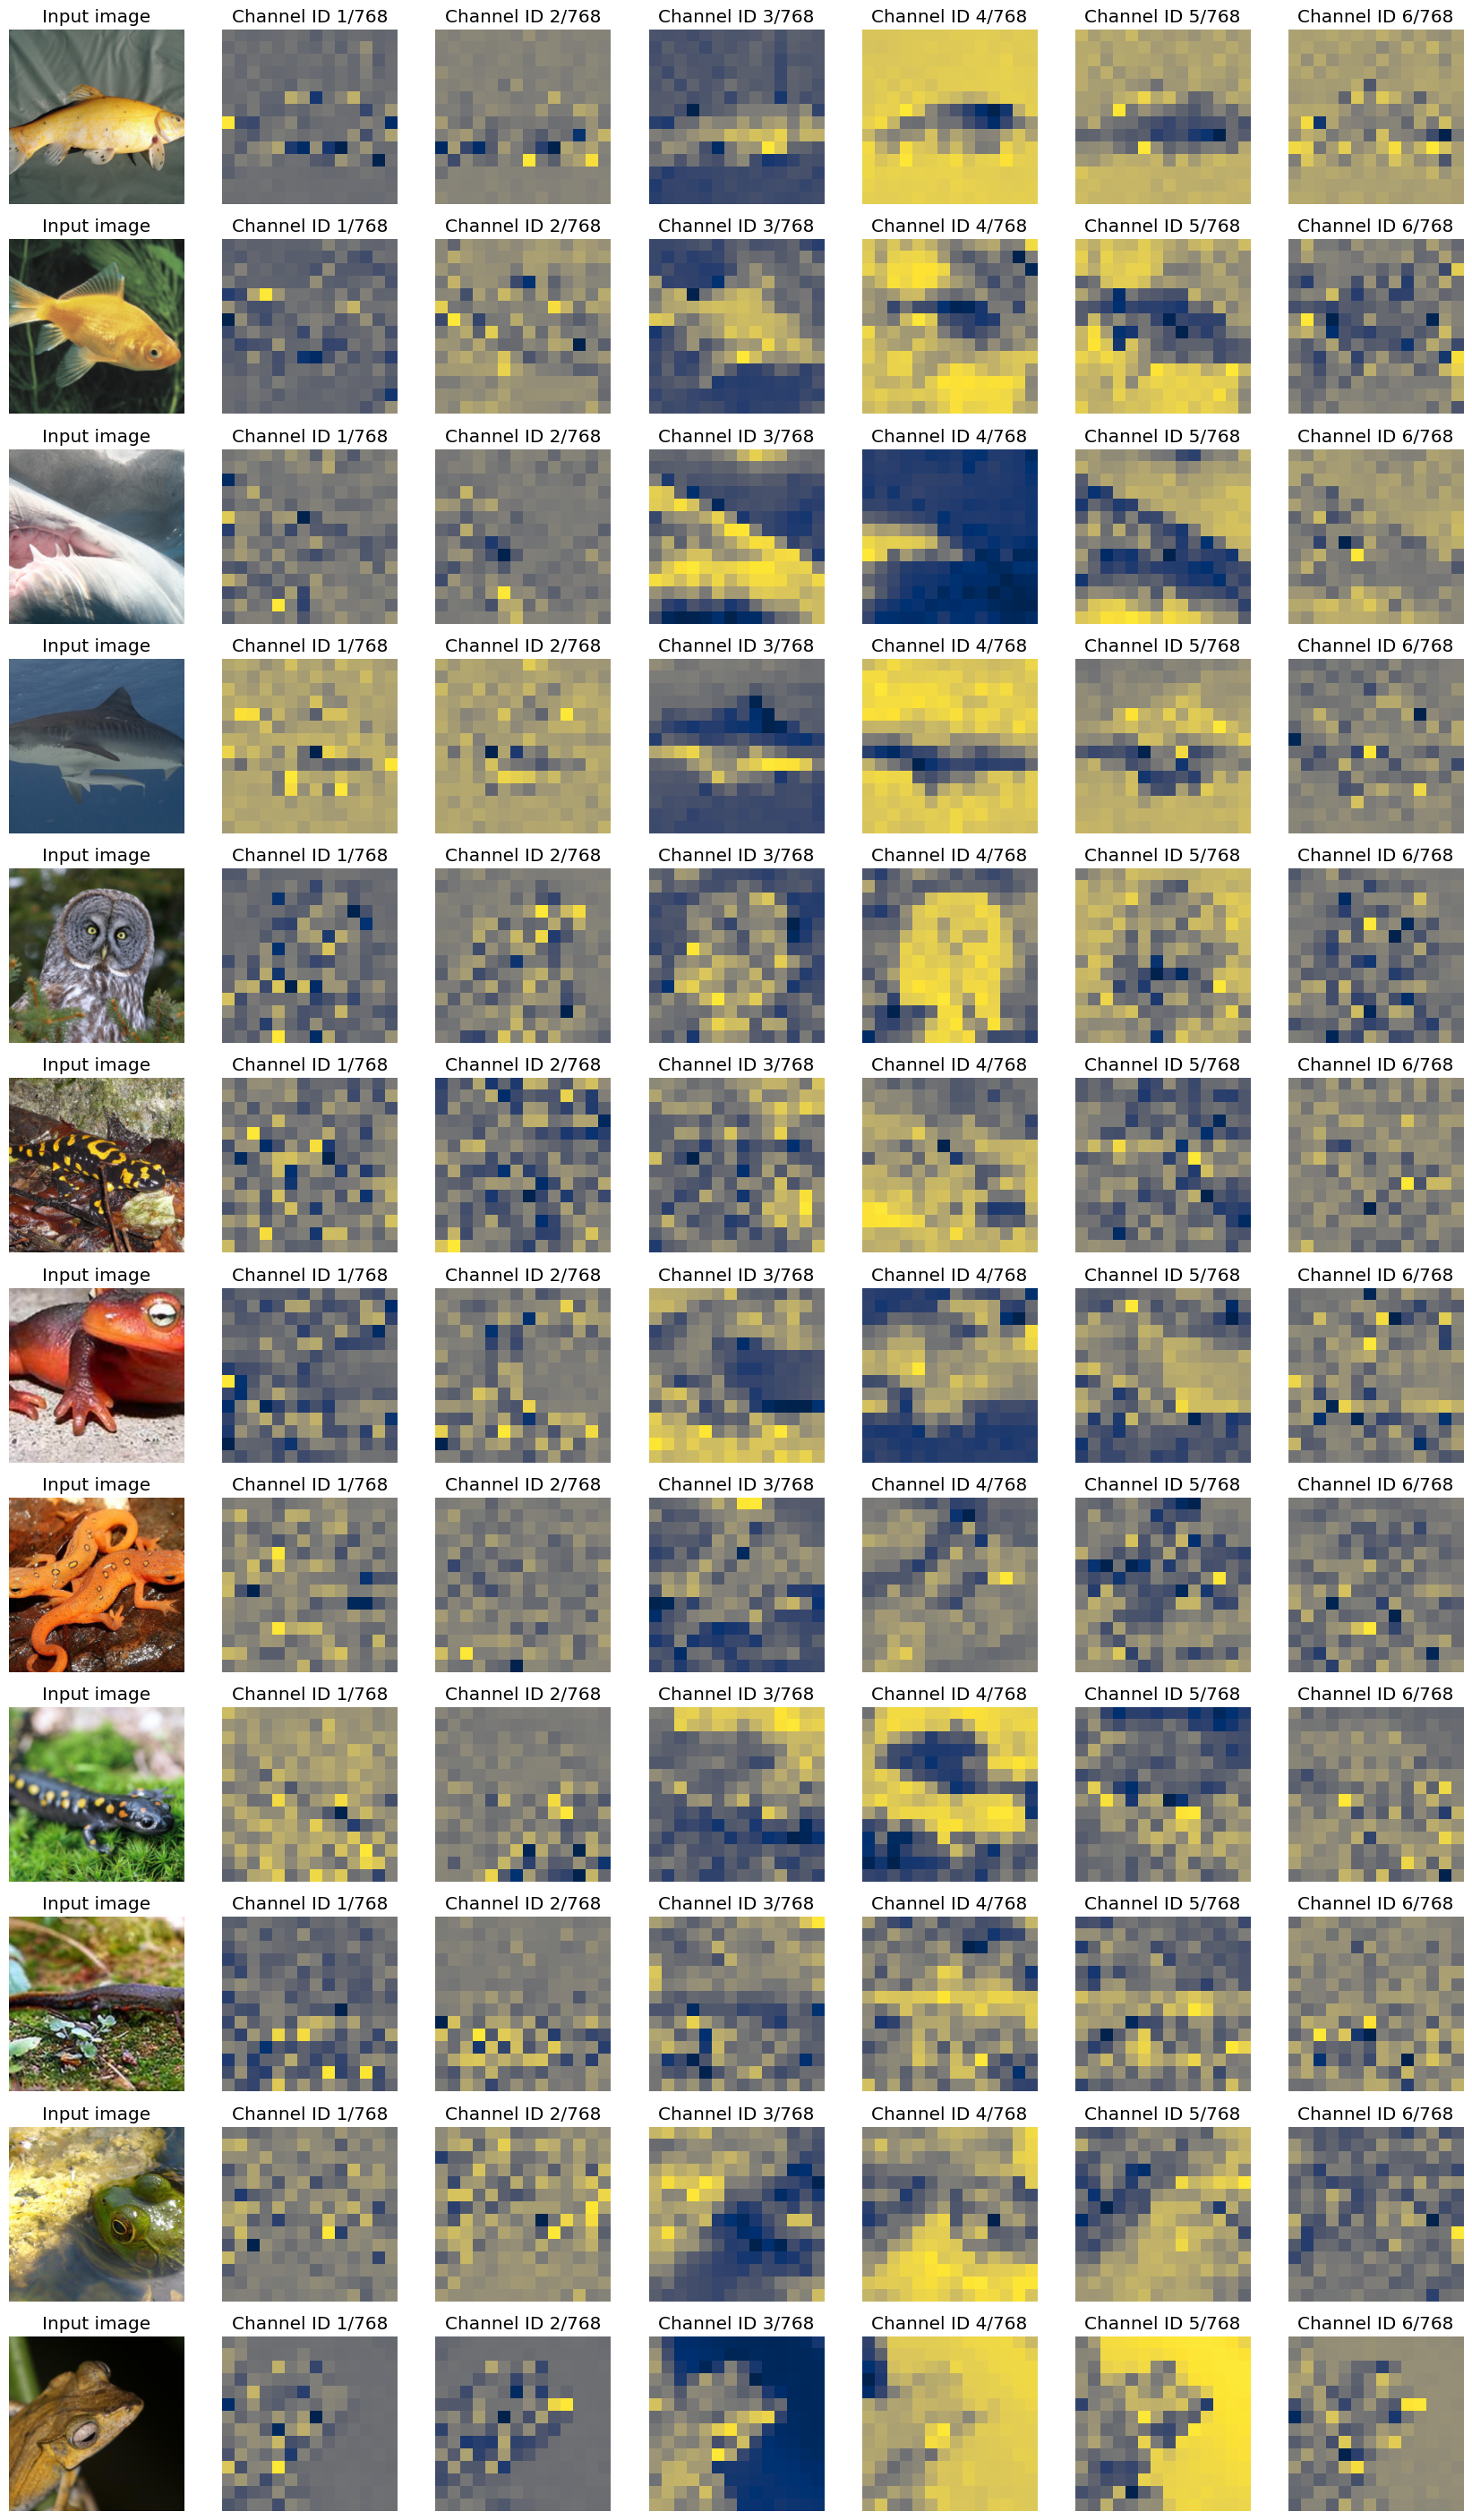

In [6]:
patch = None

class PatchEmbed_exp(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(
            self,
            img_size=224,
            patch_size=16,
            in_chans=3,
            embed_dim=768,
            **kwargs
    ):
        super().__init__()
        img_size = to_2tuple(img_size) # (224, 224)
        patch_size = to_2tuple(patch_size) # (16, 16)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        global patch

        print(f"[Patch Embedding] STEP 0. input shape: {x.shape}")
        x = self.proj(x)
        patch = x
        print(f"[Patch Embedding] STEP 1. projected shape: {x.shape}")
        x = x.flatten(2) # 정답 1
        print(f"[Patch Embedding] STEP 2. flattened shape: {x.shape}")
        x = x.transpose(1, 2) # 정답 2
        print(f"[Patch Embedding] STEP 3. transpose shape: {x.shape}")

        return x


device = 'cuda:0'
model = MyViT(embed_layer=PatchEmbed_exp, block_fn=Block).to(device)
logit = model(xs.to(device))
prob, index = torch.softmax(logit, dim=1).topk(5)
show_patch(imgs, patch, [0,1,2,3,4,5])

## 1.2. Attention 뜯어보기

### Transformer Encoder 와 Multi-headed self attention 개념

- `A = Q x K.t()`: Query `Q` 와 Key `K` 를 이용해서 Attention map `A` 을 구함.
- `MHSA(x) A x V`: Attention value `A` 와 Valeu `V` 를 이용해서 최종 아웃풋을 구함.
- 생략한 부분: softmax, output project layer, multi-head

![image](https://user-images.githubusercontent.com/31476895/219355470-803208ac-82fc-4343-a04e-5c400dee2524.png)

In [7]:
attn_map = []

class Attention_exp(nn.Module):
    """ Multi-headed Self Attention in Vision Transformer
    """
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        global attn_map

        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        print('-' * 60)
        print(f"[Attention {len(attn_map)+1}] x shape: {x.shape}")
        print(f"[Attention {len(attn_map)+1}] q shape: {q.shape}")
        print(f"[Attention {len(attn_map)+1}] k shape: {k.shape}")
        print(f"[Attention {len(attn_map)+1}] v shape: {v.shape}")
        print(f"[Attention {len(attn_map)+1}] attn shape: {attn.shape}")

        attn_map.append(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x


class Mlp_exp(nn.Module):
    """ MLP as used in Vision Transformer
    """
    def __init__(
            self,
            in_features,
            hidden_features,
    ):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class Block_exp(nn.Module):
    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4.,
            **kwargs
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention_exp(dim, num_heads=num_heads)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp_exp(in_features=dim, hidden_features=int(dim * mlp_ratio))

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


device = 'cuda:0'
model = MyViT(embed_layer=PatchEmbed, block_fn=Block_exp).to(device)
model.eval()
logit = model(xs.to(device))
prob, index = torch.softmax(logit, dim=1).topk(5)
show_attn(imgs, attn_map, layers=[1, 3, 5, 7], indices=[0, 1, 105, 190])

Output hidden; open in https://colab.research.google.com to view.

# 2. ViT 모델 구조 및 추론

## 2.1. ViT 모델 구조

- Model: ViT-B/16
- Top 1: 84.268 (%)
- Top 5: 96.802 (%)
- Parameter: 86.54 (M)
- Image size: 224 x 224 (px)
- Crop percent: 0.875 (%)
- Interpolation: bilinear

In [8]:
class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(
            self,
            img_size=224,
            patch_size=16,
            in_chans=3,
            embed_dim=768,
            **kwargs
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        return x


class Attention(nn.Module):
    """ Multi-headed Self Attention in Vision Transformer
    """
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x


class Mlp(nn.Module):
    """ MLP as used in Vision Transformer
    """
    def __init__(
            self,
            in_features,
            hidden_features,
    ):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class Block(nn.Module):
    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4.,
            **kwargs
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio))

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class MyViT(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.load_from_pretrained()

    def load_from_pretrained(self):
        url = 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tresnet/vit_base_patch16_224_1k_miil_84_4-2deb18e3.pth'
        state_dict = torch.utils.model_zoo.load_url(url, map_location='cpu')
        self.load_state_dict(state_dict)

    def _pos_embed(self, x):
        b, n, c = x.shape
        cls_token = self.cls_token.expand(b, -1, -1) # b, 1, c
        x = torch.cat([cls_token, x], dim=1) # b, n + 1, c
        x = x + self.pos_embed # b, n + 1, c
        return x

    def forward(self, x):
        x = self.patch_embed(x)
        x = self._pos_embed(x)
        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x[:, 0])
        return x

device = 'cuda:0'
model = MyViT(embed_layer=PatchEmbed, block_fn=Block).to(device)
print(model)
summary(model, (3, 224, 224))

MyViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (2): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (3): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (4): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (5): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (6): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (7): Block(
      

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
        PatchEmbed-2             [-1, 196, 768]               0
         LayerNorm-3             [-1, 197, 768]           1,536
            Linear-4            [-1, 197, 2304]       1,769,472
            Linear-5             [-1, 197, 768]         590,592
         Attention-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 3072]       2,362,368
              GELU-9            [-1, 197, 3072]               0
           Linear-10             [-1, 197, 768]       2,360,064
              Mlp-11             [-1, 197, 768]               0
            Block-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 19

## 2.2 ViT 추론 결과

In [9]:
device = 'cuda:0'
model = MyViT(embed_layer=PatchEmbed, block_fn=Block).to(device)
logit = model(xs.to(device))
prob, index = torch.softmax(logit, dim=1).topk(5)
show_prediction_with_img(prob, index, ys, imgs)

Output hidden; open in https://colab.research.google.com to view.

# 3. Hybrid 모델 구조 및 추론

## 3.1. Hybrid 모델 구조

- Model: ViT-B/16+R50
- Top 1: 84.972
- Top 5: 97.288
- Parameter: 98.95
- Image size: 384
- Crop percent: 1.0
- Interpolation: bicubic

In [10]:
device = 'cuda:0'
model = create_model('vit_base_r50_s16_384', pretrained=True).to(device)
print(model)

VisionTransformer(
  (patch_embed): HybridEmbed(
    (backbone): ResNetV2(
      (stem): Sequential(
        (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (norm): GroupNormAct(
          32, 64, eps=1e-05, affine=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): GroupNormAct(
                  32, 256, eps=1e-05, affine=True
                  (drop): Identity()
                  (act): Identity()
                )
              )
              (conv1): StdConv2dSame(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm1): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (conv2): StdConv2dSame(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (norm2): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (conv3): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm3): GroupNormAct(
                32, 256, eps=1e-05, affine=True
                (drop): Identity()
                (act): Identity()
              )
              (drop_path): Identity()
              (act3): ReLU(inplace=True)
            )
            (1): Bottleneck(
              (conv1): StdConv2dSame(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm1): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (conv2): StdConv2dSame(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (norm2): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (conv3): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm3): GroupNormAct(
                32, 256, eps=1e-05, affine=True
                (drop): Identity()
                (act): Identity()
              )
              (drop_path): Identity()
              (act3): ReLU(inplace=True)
            )
            (2): Bottleneck(
              (conv1): StdConv2dSame(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm1): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (conv2): StdConv2dSame(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (norm2): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (conv3): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm3): GroupNormAct(
                32, 256, eps=1e-05, affine=True
                (drop): Identity()
                (act): Identity()
              )
              (drop_path): Identity()
              (act3): ReLU(inplace=True)
            )
          )
        )
        (1): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
                (norm): GroupNormAct(
                  32, 

## 3.2. Hybrid 모델 추론 결과

In [11]:
logit = model(xs_384.to(device))
prob, index = torch.softmax(logit, dim=1).topk(5)
show_prediction_with_img(prob, index, ys, imgs)

Output hidden; open in https://colab.research.google.com to view.